# Imports + Variables

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random


import torch
import torch.optim as optim
from Callbacks import EarlyStopping
from torch.utils.data import DataLoader
from torchvision import transforms

from caps_normal_model import CapsuleNetwork, CapsuleLoss
from caps_utils import DICOMCoarseDataset, display_data_loader_batch, TransformDataset

In [ ]:
BASE_DIR_TRAIN = "D:/Datasets/YOLO_Caps/train"
BASE_DIR_VAL = "D:/Datasets/YOLO_Caps/val"
BASE_DIR_TEST = "D:/Datasets/YOLO_Caps/test"
seed = 41
batch_size = 16
classes = ["nodule", "non-nodule"]
train_ratio = 0.8
image_size = 128
data_augmentation = True

In [15]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Dataset

## Train Val Test Creation

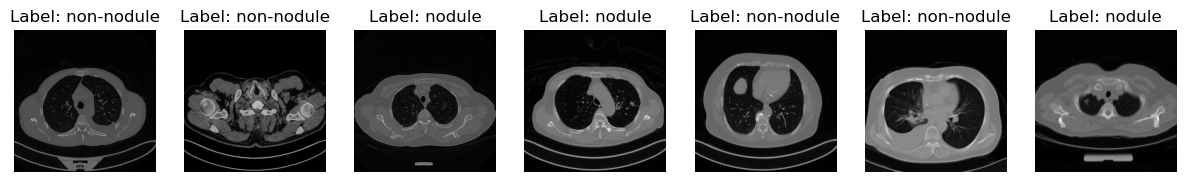

In [ ]:
# Create Datasets for train, val, test
train_dataset = DICOMCoarseDataset(root_dir=BASE_DIR_TRAIN, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TRAIN, "cropped_nodule"))), classes=classes)
val_dataset = DICOMCoarseDataset(root_dir=BASE_DIR_VAL, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_VAL, "cropped_nodule"))), classes=classes)
test_dataset = DICOMCoarseDataset(root_dir=BASE_DIR_TEST, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR_TEST, "cropped_nodule"))), classes=classes)

# Visualize x Images of the train_dataset
train_dataset.visualize_images(num_images=7)

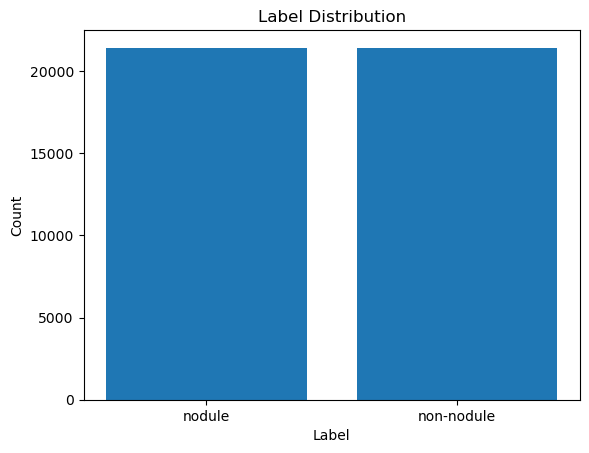

In [ ]:
# Visualize Distribution 
train_dataset.display_label_distribution()

## Dataset Transformation & Augmentation

In [ ]:
# Create augmentation variable
train_transforms = None 

# Basic transform
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# if data augmentation is wanted (true in variables) then add Augmentations + Transform, else only transform
if data_augmentation:
    train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),            # Flip image horizontal
        transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
        transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
        transform
    ])
else: 
    train_transforms = transform

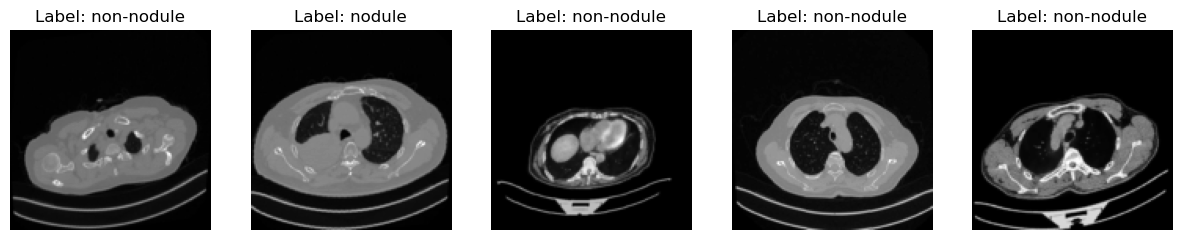

In [ ]:
# Transform all 3 datasets
train_dataset = TransformDataset(train_dataset, transform=train_transforms)
val_dataset = TransformDataset(val_dataset, transform=train_transforms)
test_dataset = TransformDataset(test_dataset, transform=transform)

# Save as dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# display 5 images (number predefined in display_data_loader_batch) of a batch
display_data_loader_batch(train_loader, classes)

# Model

## Model definition

In [ ]:
# Check if GPU is available
TRAIN_ON_GPU = torch.cuda.is_available()

# Define CapsuleNetwork model
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)

# Show model architecture
print(capsule_net)

# Load model on GPU if GPU is available
if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=16384, bias=True)
      (5): Sigmoid()
    )
  )
)


In [ ]:
# Define Loss
criterion = CapsuleLoss()

# Define Optimizer
optimizer = optim.Adam(capsule_net.parameters())

# Define early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.0001)

## Training

In [ ]:
# max training duration
n_epochs = 100

# train model and save train and validation loss of all epochs
train_losses, val_losses = capsule_net.train_model(train_loader, val_loader, criterion, optimizer, n_epochs, early_stopping, print_every=1)

Epoch 1/100 ----- Loss: 5.2029, Accuracy: 63.66% ----- Validation Loss: 0.3217, Validation Accuracy: 69.17%
New best model saved
Epoch 2/100 ----- Loss: 5.1289, Accuracy: 68.26% ----- Validation Loss: 0.3197, Validation Accuracy: 70.31%
New best model saved
Epoch 3/100 ----- Loss: 5.1022, Accuracy: 70.61% ----- Validation Loss: 0.3183, Validation Accuracy: 72.49%
New best model saved
Epoch 4/100 ----- Loss: 5.0816, Accuracy: 72.35% ----- Validation Loss: 0.3171, Validation Accuracy: 73.92%
New best model saved
Epoch 5/100 ----- Loss: 5.0688, Accuracy: 73.50% ----- Validation Loss: 0.3164, Validation Accuracy: 75.41%
New best model saved
Epoch 6/100 ----- Loss: 5.0594, Accuracy: 74.56% ----- Validation Loss: 0.3160, Validation Accuracy: 75.22%
New best model saved
Epoch 7/100 ----- Loss: 5.0507, Accuracy: 75.24% ----- Validation Loss: 0.3157, Validation Accuracy: 76.19%
New best model saved
Epoch 8/100 ----- Loss: 5.0421, Accuracy: 76.36% ----- Validation Loss: 0.3150, Validation Accura

# Results

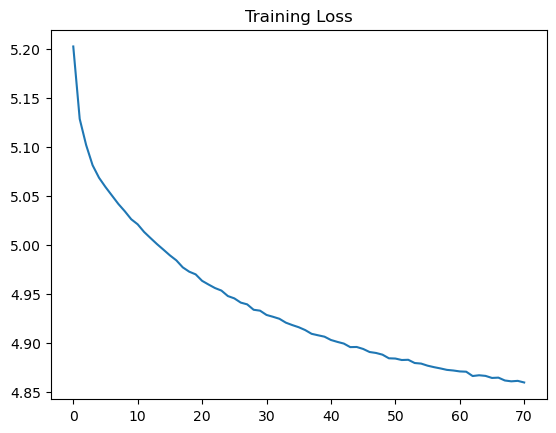

In [ ]:
# Plot loss of training
plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

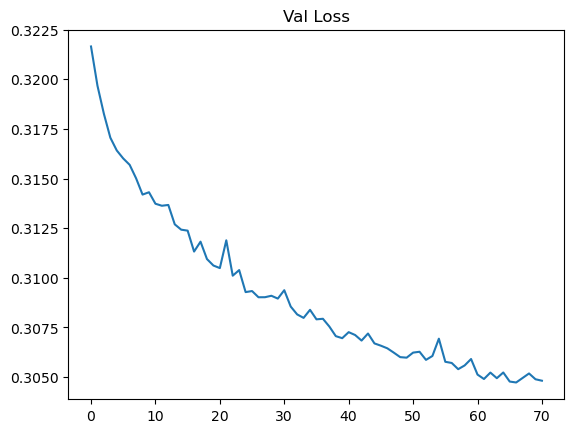

In [ ]:
# Plot loss of validation
plt.plot(val_losses)
plt.title("Val Loss")
plt.show()

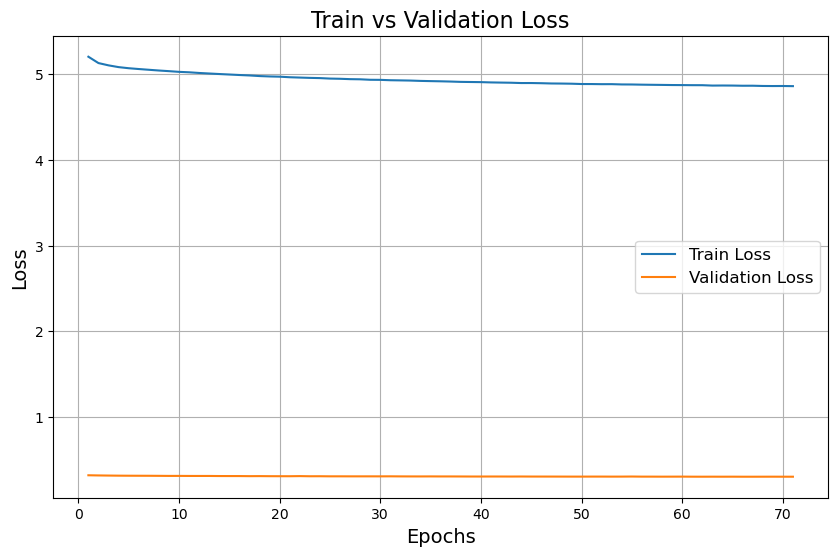

In [ ]:
# Visualize both losses together 

# Assumption: train_losses and val_losses are lists containing the loss values
# Check if both lists have the same length
assert len(train_losses) == len(val_losses), "Train and validation losses have different lengths!"

# Create the epoch list (x-axis)
epochs = range(1, len(train_losses) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

# Title and axis labels
plt.title('Train vs Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.show()